In [1]:
import sys
sys.path.append('..')
from src.pomdp import *

import numpy as np

## 2-state 2-action symmetric problem

In [2]:
ACTION_COUNT = 2
STATE_COUNT = 2

In [3]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup table to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            transition_table[s,a,s_p] = transition_function(s,a,s_p)

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.8, 0.2],
       [0.2, 0.8]])

In [4]:
OBS_RND = 0.7 # 70% of observation success

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for o in range(STATE_COUNT):
            observation_table[s_p, a, o] = OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)
          
observation_table[:,0,0]

array([0.7, 0.3])

In [5]:
REWARD_PROBS = [0.2, 0.6]

reward_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            reward_table[s,a,s_p,:] = REWARD_PROBS[s_p]
        
reward_table

array([[[[0.2, 0.2],
         [0.6, 0.6]],

        [[0.2, 0.2],
         [0.6, 0.6]]],


       [[[0.2, 0.2],
         [0.6, 0.6]],

        [[0.2, 0.2],
         [0.6, 0.6]]]])

In [6]:
states = ['s0','s1']
actions = ['stay', 'move']
observations = ['s0', 's1']

model = Model(states, actions, observations, transition_table, reward_table, observation_table, probabilistic_rewards=True)

## Run 100 iterations of backup for 100 different belief sets

In [7]:
c = 100

belief_sets = [ [Belief(model, np.array([i/c, 1.0 - (i/c)])), Belief(model, np.array([1.0 - (i/c), i/c]))] for i in range(int((c/2)+1))]

In [8]:
solver = PBVI_Solver(gamma=0.99)

In [9]:
print(belief_sets[0])

[Belief([0., 1.]), Belief([1., 0.])]


In [10]:
value_functions = []

init_value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
eps = 0.001

for belief_set in belief_sets:
    vf = copy.deepcopy(init_value_function)
    old_max_val_per_belief = None
    # belief_set = [belief_set[0]]

    for iter in range(1000):
        vf = solver.backup(model, belief_set, vf)

        max_val_per_belief = np.max(np.matmul(np.array(belief_set), np.array(vf).T), axis=1)
        if old_max_val_per_belief is not None:
            max_change = np.max(np.abs(max_val_per_belief - old_max_val_per_belief))
            if max_change < eps:
                # print('early convergence')
                break
        old_max_val_per_belief = max_val_per_belief

    print(f'belief s0 {belief_set[0]} - max {np.max(vf)} - min {np.min(vf)} (iter count {iter})')


    value_functions.append(vf)

belief s0 [0. 1.] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)


belief s0 [0.01 0.99] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.02 0.98] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.03 0.97] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.04 0.96] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.05 0.95] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.06 0.94] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.07 0.93] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.08 0.92] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.09 0.91] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.1 0.9] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.11 0.89] - max 40.197412873596306 - min 39.6062798686702 (iter count 596)
belief s0 [0.12 0.88] - max 40.19741287359630

In [11]:
all_vectors = []
for avs in value_functions[:-1]:
    all_vectors += avs

all_vectors = np.array(all_vectors)

<Figure size 800x500 with 0 Axes>

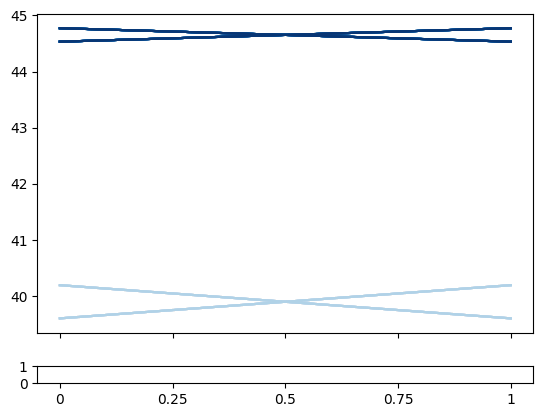

In [12]:
x = np.linspace(0, 1, 100)

plt.figure(figsize=(8,5))
grid_spec = {'height_ratios': ([1] if belief_set is None else [19,1])}
_, ax = plt.subplots(2,1,sharex=True,gridspec_kw=grid_spec)

# Vector plotting
m = all_vectors[:,1] - all_vectors[:,0] # type: ignore
m = m.reshape(m.shape[0],1)

x = x.reshape((1,x.shape[0])).repeat(m.shape[0],axis=0)
y = (m*x) + all_vectors[:,0].reshape(m.shape[0],1)

ax1 = ax[0]
colors = plt.get_cmap('Blues') # type: ignore

for i in range(0, all_vectors.shape[0]):
    ax1.plot(x[i,:], y[i,:], c=colors(int((int(i/2)/50)*255))) # type: ignore

# X-axis setting
ticks = [0,0.25,0.5,0.75,1]
x_ticks = [str(t) for t in ticks]

ax1.set_xticks(ticks, x_ticks) # type: ignore

MDP problem

In [13]:
from src.mdp import VI_Solver

In [14]:
vi_solver = VI_Solver()

In [15]:
vf, solver_history = vi_solver.solve(model)

<Figure size 700x500 with 0 Axes>

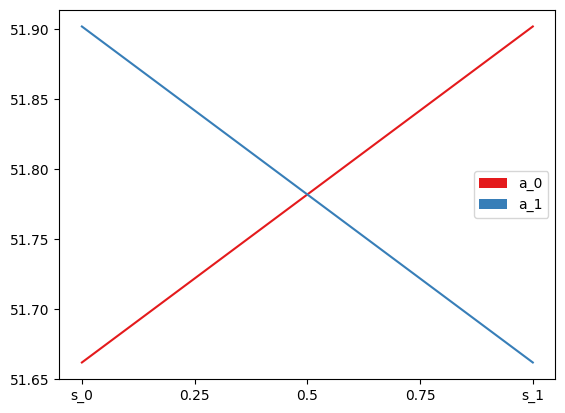

In [16]:
vf.plot()

We can see there is a different convergence of the value depending on the belief set used, it converges to two different value function depending on a belief threshold.

Between [0.00 1.00] and [0.16 0.84] beliefs, we can see it converges to a value function that is lower than the value function for beliefs between [0.17 0.83] and [0.50 0.50] where the value function is higher. This could signify that 0.84 would be the certainty threshold beyond which the agent is sure about his action and can aim to maximize his gains. Under this, in uncertainty, the value function needs to reach higher to converge, also shown by the amount of iterations required to converged, 596 vs 607

## Equal belief set, different observation probs

In [17]:
all_beliefs = []

for beliefs in belief_sets:
    all_beliefs.extend(beliefs)

In [25]:
obs_rnds = np.linspace(0.5,1.0,51)

obs_tables = []
for i in range(obs_rnds.shape[0]):
    observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
    obs_rnd = obs_rnds[i]
    for s_p in range(STATE_COUNT):
        for a in range(ACTION_COUNT):
            for o in range(STATE_COUNT):
                observation_table[s_p, a, o] = obs_rnd if s_p == o else (1.0 - obs_rnd) / (STATE_COUNT - 1)

    obs_tables.append(observation_table)

In [32]:
value_functions = []

init_value_function = ValueFunction(model, [AlphaVector(model.expected_rewards_table[:,a], a) for a in model.actions])
eps = 0.001

for i, obs_table in enumerate(obs_tables):
    vf = copy.deepcopy(init_value_function)
    old_max_val_per_belief = None

    model.observation_table = obs_table

    for iter in range(1000):
        vf = solver.backup(model, all_beliefs, vf)

        max_val_per_belief = np.max(np.matmul(np.array(all_beliefs), np.array(vf).T), axis=1)
        if old_max_val_per_belief is not None:
            max_change = np.max(np.abs(max_val_per_belief - old_max_val_per_belief))
            if max_change < eps:
                # print('early convergence')
                break
        old_max_val_per_belief = max_val_per_belief

    print(f'obs rnd {obs_rnds[i]} - max {np.max(vf)} - min {np.min(vf)} (iter count {iter})')


    value_functions.append(vf)

obs rnd 0.5 - max 40.197412873596534 - min 39.60627986867041 (iter count 596)
obs rnd 0.51 - max 40.429917334553 - min 39.84738119400616 (iter count 604)
obs rnd 0.52 - max 40.659569115311264 - min 40.08691614633852 (iter count 597)
obs rnd 0.53 - max 40.896434651339185 - min 40.331567847665326 (iter count 598)
obs rnd 0.54 - max 41.13320397936461 - min 40.58092593908731 (iter count 598)
obs rnd 0.55 - max 41.37172212935587 - min 40.825318846100004 (iter count 599)
obs rnd 0.56 - max 41.60871691473529 - min 41.08168530678784 (iter count 599)
obs rnd 0.5700000000000001 - max 41.84697021041493 - min 41.32102947746533 (iter count 600)
obs rnd 0.58 - max 42.08347393092769 - min 41.56379909701184 (iter count 600)
obs rnd 0.59 - max 42.32046293444447 - min 41.81319485975069 (iter count 601)
obs rnd 0.6 - max 42.55619840185018 - min 42.049703222042204 (iter count 602)
obs rnd 0.61 - max 42.78975372830734 - min 42.28863844173246 (iter count 602)
obs rnd 0.62 - max 43.02275054481007 - min 42.52

In [35]:
value_functions[-10]

[AlphaVector([49.52356104, 49.76356104]),
 AlphaVector([49.76356104, 49.52356104])]

<Figure size 800x500 with 0 Axes>

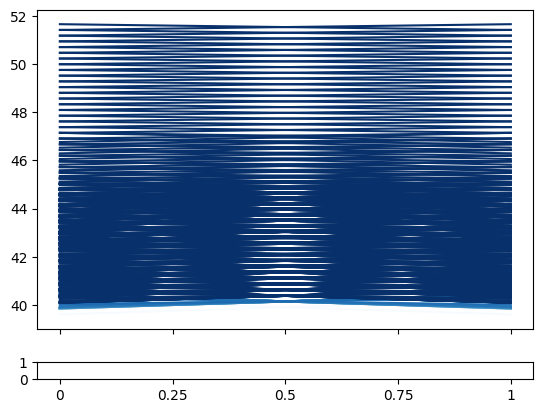

In [33]:
all_vectors = []
for avs in value_functions[:-1]:
    all_vectors += avs

all_vectors = np.array(all_vectors)

x = np.linspace(0, 1, 100)

plt.figure(figsize=(8,5))
grid_spec = {'height_ratios': ([1] if belief_set is None else [19,1])}
_, ax = plt.subplots(2,1,sharex=True,gridspec_kw=grid_spec)

# Vector plotting
m = all_vectors[:,1] - all_vectors[:,0] # type: ignore
m = m.reshape(m.shape[0],1)

x = x.reshape((1,x.shape[0])).repeat(m.shape[0],axis=0)
y = (m*x) + all_vectors[:,0].reshape(m.shape[0],1)

ax1 = ax[0]
colors = plt.get_cmap('Blues') # type: ignore

for i in range(0, all_vectors.shape[0]):
    ax1.plot(x[i,:], y[i,:], c=colors(int((int(i/2)/50)*255))) # type: ignore

# X-axis setting
ticks = [0,0.25,0.5,0.75,1]
x_ticks = [str(t) for t in ticks]

ax1.set_xticks(ticks, x_ticks) # type: ignore